In [162]:
import numpy as np
from numpy import random
import cv2

from skimage.segmentation import slic, mark_boundaries
from skimage import io
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.color
from skimage.future import graph
from skimage import feature, transform
from skimage import measure
from skimage import exposure
from skimage.feature import local_binary_pattern
from skimage.measure import regionprops
from skimage.feature import greycomatrix, greycoprops

from scipy.spatial.distance import pdist

import networkx as nx
import timeit

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style="ticks", color_codes=True)

%matplotlib inline

In [2]:
font_dict = {'family': 'sans',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

In [3]:
def show_image(img):
    f = plt.figure(figsize=(8, 12))
    plt.imshow(img)
    plt.axis('off');

In [4]:
def masking_image(img, mask):
    dst = img.copy()
    dst[:,:,1] = dst[:,:,1] * mask
    return dst

In [5]:
def weight_boundary(graph, src, dst, n):
    default = {'weight': 0.0, 'count': 0}

    count_src = graph[src].get(n, default)['count']
    count_dst = graph[dst].get(n, default)['count']

    weight_src = graph[src].get(n, default)['weight']
    weight_dst = graph[dst].get(n, default)['weight']

    count = count_src + count_dst
    return {
        'count': count,
        'weight': (count_src * weight_src + count_dst * weight_dst)/count
    }

def merge_boundary(graph, src, dst):
    pass

In [6]:
def floor_label(labels):
    """takes the lable value from the central lower part of image"""
    h, w = labels.shape
    potential_floor = labels[int(h/2):, int(w/4):int(w*3/4)]
    
#     fig, ax = plt.subplots(1,2)
#     ax[0].imshow(labels)
#     ax[1].imshow(potential_floor)
    
    # choose the biggest segments 
    unique, counts = np.unique(potential_floor, return_counts=True)
    res_dict = dict(zip(unique, counts))
    main_label = sorted(res_dict.items(), key=lambda kv: kv[1], reverse=True)[0][0]
#     return labels[int(h*0.8), int(w*0.5)]
    return main_label

In [7]:
def weight_histogram(g_edg, percent_thresh = 0.80):
    """plot histogram of RAG edges weights and return threshold for a given percentile"""
    from scipy.stats import percentileofscore
    w_list = list(g_edg.edges(data='weight'))
    weights = np.asarray([w[2] for w in w_list])
    percentile = np.quantile(weights, percent_thresh)
    return percentile

### Loading image

/home/dzyga/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/dzyga/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/dzyga/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/dzyga/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will

Image shape resized to  (375, 500, 3)


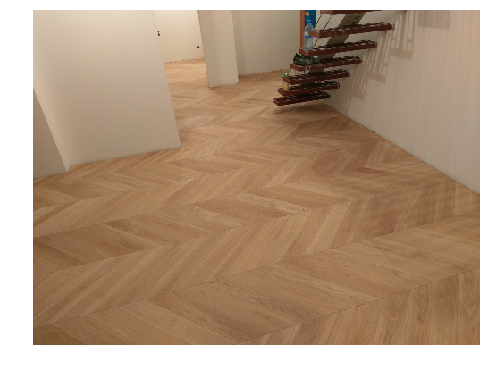

In [8]:
evaluation = True # False #False #True

# file = '4.jpg'
# file = 'img0.png'
# file = './Fwd_ floor segmentation proposal/image1.jpeg'
# fname = '50917092_2014590568590932_4249364050510610432_o.jpg' # chair in the corner
# fname = '82053699_2482903105153946_2058936514871558144_n.jpg' # floor with deep contrast
# fname = '70120232_2473173446084559_2338160950193946624_n.jpg' # 
fname = '46485749_1919646444752012_4789851260549332992_o.jpg'
# fname = '46485749_1919646444752012_4789851260549332992_o.jpg' # test 
# fname = 'Walczak_9.jpg'
file = './dataset/' + fname 

# custom mask
mask_dir = './' 
file_mask = mask_dir + '46485749_1919646444752012_4789851260549332992_o.png'
mask_cust = io.imread(file_mask)

img = io.imread(file)
img_original = img.copy()

if evaluation:
    file_gt = './dataset/ground_truth/' + fname
    img_gt = io.imread(file_gt)
    img_gt = img_gt[:,:,0]
    img_gt[img_gt <= 125] = 0
    img_gt[img_gt > 125] = 1
else:
    img_gt = np.zeros_like(img)

imh, imw, imc = img.shape
imh_orig = imh
imw_orig = imw
if imh > 600 and imh < 1000: 
    img = transform.resize(img, (int(imh/2), int(imw/2)))
    mask_gt = transform.resize(img_gt, (int(imh/2), int(imw/2)))
    mask_cust = transform.resize(mask_cust, (int(imh/2), int(imw/2)))
    print('Image shape resized to ', img.shape)
    imh, imw, imc = img.shape
elif imh > 1000:
    img = transform.resize(img, (int(imh/4), int(imw/4)))
    mask_gt = transform.resize(img_gt, (int(imh/4), int(imw/4)))
    mask_cust = transform.resize(mask_cust, (int(imh/4), int(imw/4)))
    print('Image shape resized to ', img.shape)
    imh, imw, imc = img.shape
else:
    mask_gt = img_gt
    


hsvimg = skimage.color.rgb2hsv(img)
himg = hsvimg[:,:,0]
simg = hsvimg[:,:,1]
vimg = hsvimg[:,:,2]
gimg = skimage.color.rgb2gray(img)

show_image(img)

In [9]:
# Histogram equalization
img_adapteq = exposure.equalize_adapthist(hsvimg, clip_limit=0.3)

/home/dzyga/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


### SLIC Superpixels

Number of unique labels is  298


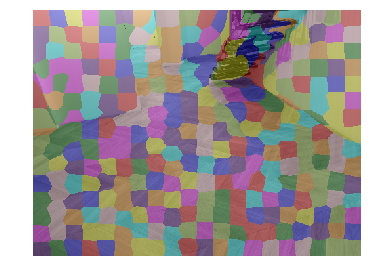

In [10]:
num_segmnts = 300
img_labels_slic = slic(img, n_segments = num_segmnts, sigma = 5, compactness = 7)

io.imshow(skimage.color.label2rgb(img_labels_slic, img))
plt.axis('off'); 
print('Number of unique labels is ', len(np.unique(img_labels_slic)))

### RAG and clustering

In [11]:
METHOD = 'var'
radius = 5
n_points = 8 * radius
lbp2 = local_binary_pattern(simg, n_points, radius, METHOD)
lbp3 = local_binary_pattern(vimg, n_points, radius, METHOD)
lbp = lbp3+lbp2
# Handling missing values
lbp[np.isnan(lbp)] = np.nanmean(lbp)
# Smooth edges of image
x = 5
lbp[:, :x] = np.median(lbp)
lbp[:x, :] = np.median(lbp)
lbp[-x:, :] = np.median(lbp)
lbp[:, -x:] = np.median(lbp)

# plt.imshow(lbp), plt.title('Edge map by LBP'), plt.axis('off');

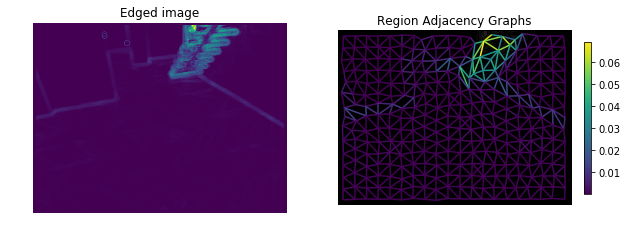

In [12]:
# Edge map
# edges = filters.sobel(simg)
edges = lbp
edges_rgb = skimage.color.gray2rgb(edges)

# Graph 
g_edg = graph.rag_boundary(img_labels_slic, edges, connectivity=2)

fig, axes = plt.subplots(1,2, figsize=(10, 8), sharey=True)
axes[0].set_title('Edged image')
axes[0].imshow(edges)
axes[0].axis('off')
axes[1].set_title('Region Adjacency Graphs')
lc = graph.show_rag(img_labels_slic, g_edg, edges_rgb, img_cmap=None, edge_cmap='viridis', ax=axes[1])
axes[1].axis('off')
fig.colorbar(lc, fraction=0.03);


In [13]:
# hierarchical merging
w_list = list(g_edg.edges(data='weight'))
weights = np.asarray([w[2] for w in w_list])
Q = np.quantile(weights, 0.65)
img_labels_merged = graph.merge_hierarchical(img_labels_slic, g_edg, Q, rag_copy=True,
                                   in_place_merge=True,
                                   merge_func=merge_boundary,
                                   weight_func=weight_boundary)

# show_image(color.label2rgb(img_labels_merged, img, kind='avg'))

# floor mask from merged labels
target_label = floor_label(img_labels_merged)
mask_merged = np.zeros(img_labels_merged.shape, dtype=np.float32)
mask_merged[img_labels_merged == target_label] = 1

# fig, axes = plt.subplots(1,2, figsize=(10, 8), sharey=True)
# axes[0].set_title('Merged segments')
# axes[0].imshow(skimage.color.label2rgb(img_labels_merged, img, kind='avg'))
# axes[0].axis('off')
# axes[1].set_title('Floor mask')
# axes[1].imshow(mask_merged)
# axes[1].axis('off');

## Clustering by features

In [14]:
# Change label image here 
img_labels = img_labels_slic 
segments = regionprops(img_labels, simg)

### GLCM feature  

In [15]:
def get_glcm_features(patch):
    """fet glcm feature for the input patch
    of an image """
    patch = cv2.convertScaleAbs(patch)
    # list of GLCM feature 
    features = [
     'dissimilarity', 
     'homogeneity', 
     'energy',
#      'correlation',
     'contrast',
     'ASM']

    N = len(features)
    feature_vec = np.zeros(N)
    glcm_img = greycomatrix(patch, [5], [0, np.pi/4, np.pi/2, 3*np.pi/4],
                            levels=256, normed=True)
    for j,f in enumerate(features):
        feature_vec[j] = greycoprops(glcm_img, f)[0,0]
    return feature_vec.reshape(1,-1)
# get_glcm_features(patch)

In [16]:
# GLCM feature 

# for whole picture - to normalize 
feature_vec_image = get_glcm_features(simg)

# for segments in image 
N = feature_vec_image.shape[1]
M = len(segments) 
    
feature_matr = np.zeros([M,N])
for i,props in enumerate(segments):
    feature_matr[i, :] = get_glcm_features(props.intensity_image.squeeze())

## Classification 

/home/dzyga/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


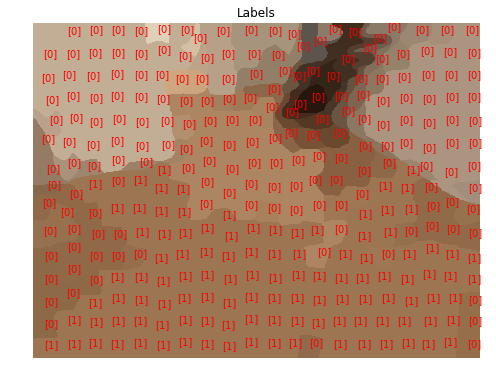

In [17]:
y_label = np.zeros((len(segments),1))
for i,props in enumerate(segments):
    r, c = props.centroid
    y_label[i] = mask_merged[int(r),int(c)]
y_label = y_label.astype('int')

show_image(skimage.color.label2rgb(img_labels_merged, img, kind='avg'))
for i,props in enumerate(segments):
    cx, cy = props.centroid  # centroid coordinates
    plt.text(int(cy), int(cx), y_label[i], fontsize=10, color='red')
plt.axis('off')#
plt.title('Labels');

### LBP features 

In [18]:
# # LBP

# Nlbp = len(lbp_methods)
# # Mlbp = len(segments)
 
# def get_lbp_features(patch):
#     patch = cv2.convertScaleAbs(patch)
#     radius = 3
#     n_points = 8 * radius
#     lbp_methods = ['uniform',
#                'default', 
#                'ror',
#                'nri_uniform',
#                'var']
#     Nbins = 8
#     for method in lbp_methods:
#         lbp_patch = np.zeros([Mlbp, Nbins])
#         lbp  = local_binary_pattern(patch, n_points, radius, method)
# #         feature_hist, _ = np.histogram(lbp, bins = Nbins)
# #         lbp_matr[i, :] = feature_hist
# #     feature_matr = np.hstack((feature_matr,lbp_matr))

In [19]:
# lbp_matr = np.zeros([Mlbp, Nbins])
# for i, props in enumerate(segments):
#     patch = cv2.convertScaleAbs(props.intensity_image.squeeze())
#     lbp  = local_binary_pattern(patch, n_points, radius, METHOD)
#     feature_hist, _ = np.histogram(lbp, bins = Nbins)
#     lbp_matr[i, :] = feature_hist
# feature_matr = np.hstack((feature_matr,lbp_matr))

### Clustering

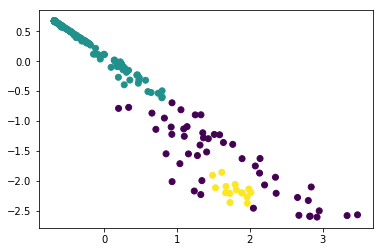

In [20]:
from sklearn.preprocessing import scale
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
# from sklearn.decomposition import PCA

# !!!!!!!!!!!!!!!!!!! Handling NaN 
feature_matr[np.isnan(feature_matr)] = 0
data = scale(feature_matr) # features for slic or merged segments 
n_samples, n_features = data.shape

# # K-Means
# n_clusters = 5
# kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10).fit(data)
# y_pred = kmeans.predict(data)
# plt.scatter(data[:, 0], data[:, 2], c=y_pred);

# DBSCAN
db = DBSCAN(eps=0.4, min_samples=10).fit(data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
y_pred = db.labels_
plt.scatter(data[:, 0], data[:, 2], c=y_pred);

In [21]:
# group im clusters by predicted labels by filling segments (x,y) wiht corresponding label 
img_labels_pred = np.zeros_like(img_labels) 
for i, props in enumerate(segments):
    for r, c in props.coords:
        img_labels_pred[r,c] = y_pred[i]
# show_image(img_labels_pred)
type(img_labels_pred[0,0])

numpy.int64

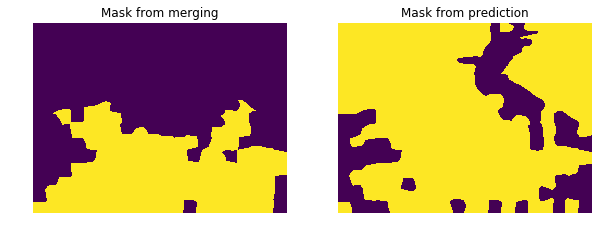

In [22]:
# grab the floor label in predicted mask
target_label = floor_label(img_labels_pred)
mask_pred = np.zeros(img_labels_pred.shape, dtype=np.float32)
mask_pred[img_labels_pred == target_label] = 1

# show and compare two masks
fig, axes = plt.subplots(1,2, figsize=(10, 8), sharey=True)
axes[0].set_title('Mask from merging')
axes[0].imshow(mask_merged)
axes[0].axis('off')
axes[1].set_title('Mask from prediction')
axes[1].imshow(mask_pred)
axes[1].axis('off');

## Post processing

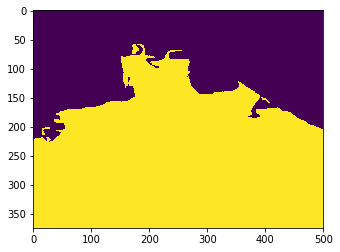

In [24]:
# choose a mask to post process 
# mask = mask_merged

mask = mask_cust
mask[mask>0]=1
plt.imshow(mask);

### Give unique labels to areas under the contours

6 :
111728.0
121.5
44.5
40.0
31.5
6.0


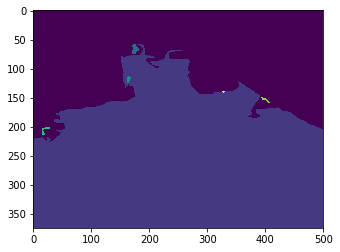

In [25]:
# Original image 
contours, hierarchy = cv2.findContours(cv2.convertScaleAbs(mask),
                                       cv2.RETR_CCOMP, #cv2.RETR_TREE, # 
                                       cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key = cv2.contourArea,reverse=True)
print(len(contours), ':')
map_orig = np.ones(mask.shape)
for i, cnt in enumerate(contours):
    print(cv2.contourArea(cnt))
#     c = np.random.randint(1, 254)
    c = i*2+3
    cv2.fillPoly(map_orig, [cnt], color = c) 
plt.imshow(map_orig);
map_orig = map_orig.astype(np.int)

cont_or = contours

In [116]:
# Inverted image 
contours, hierarchy = cv2.findContours(cv2.convertScaleAbs(np.max(mask)-mask),
                                       cv2.RETR_CCOMP, #cv2.RETR_TREE, # 
                                       cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key = cv2.contourArea, reverse=True)
map_inv = np.ones(mask.shape)*255
for i, cnt in enumerate(contours):
    print(cv2.contourArea(cnt))
#     c = np.random.randint(1,254)
    c = 254 - i*2
    cv2.fillPoly(map_inv, [cnt], color = c) 
plt.imshow(map_inv);
map_inv = map_inv.astype(np.int)

cont_inv = contours

73871.0
164.5
90.0
64.5
21.5


dtype('int32')

In [160]:
all_contours = cont_or + cont_inv
all_contours = sorted(all_contours, key = cv2.contourArea, reverse=True)
print(len(all_contours))

11


In [ ]:
# true_contours = []
# for cnt in all_contours:
#     M = cv2.moments(cnt)
#     x = M["m10"] / M["m00"]
#     y = M["m01"] / M["m00"]
#     for cnt1 in true_contours:
#         M1 = cv2.moments(cnt)
#         x1 = M1["m10"] / M1["m00"]
#         y1 = M1["m01"] / M1["m00"]
#         d = (np.sqrt((x-x1)**2+(y-y1)**2))
#         if d < 10: 
#         true_contours.append(cnt)

In [138]:
# centr = []
# for i, cnt in enumerate(true_contours):
#     M = cv2.moments(cnt)
#     x = M["m10"] / M["m00"]
#     y = M["m01"] / M["m00"]
#     centr.append((x,y))
# len(centr)

11

/home/dzyga/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


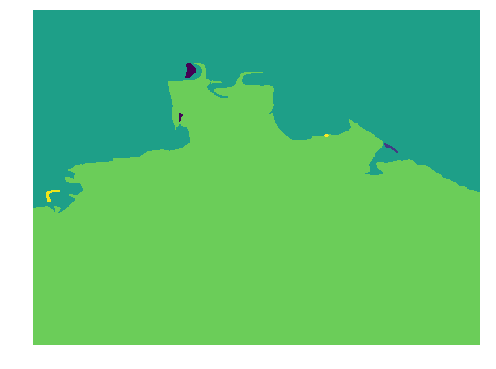

In [163]:
true_contours_compare = true_contours.copy()

map_tmp=np.zeros((map_inv.shape))
for i, cnt in enumerate(true_contours):
    M = cv2.moments(cnt)
    x = M["m10"] / M["m00"]
    y = M["m01"] / M["m00"]
    for j in range(i+1,len(centr)):
        x1 = centr[j][0]
        y1 = centr[j][1]
        d = (np.sqrt((x-x1)**2+(y-y1)**2))
        if d < 10:
            try: 
                true_contours_compare.remove(cnt)
            except:
                print('Already done')
                
for cnt in true_contours_compare:
    c = np.random.randint(1,254)
    cv2.fillPoly(map_tmp, [cnt], color = c)
show_image(map_tmp)        

In [101]:
# # true_contours = [y for x in [cont_or, cont_inv] for y in x] # 
# true_contours = cont_or + cont_inv
# true_contours = sorted(true_contours, key = cv2.contourArea, reverse=True)
# print(len(true_contours))

# cX1 = 0
# cY1 = 0
# map_tmp = np.zeros(mask.shape)
# for i, cnt in enumerate(true_contours):
#     print(cv2.contourArea(cnt), ' -> ', cX, cY)
#     M = cv2.moments(cnt)
#     cX = int(M["m10"] / M["m00"])
#     cY = int(M["m01"] / M["m00"])
#     d = np.sqrt((cX1-cX)**2+(cY1-cY)**2)
#     if d > 10:
#  #     c = np.random.randint(1,254)
#         c = 254 - i*2
#         cv2.fillPoly(map_tmp, [cnt], color = c) 
#     else:
#         print('Kill!!!!')
#     cX1 = cX
#     xY1 = cY
# show_image(map_tmp);

In [102]:
# from scipy.spatial import distance
# np.linalg.norm(np.asarray([cX1, cY1]) - np.asarray([cX,cY]))
# # distance.euclidean(np.asarray(segments_postproc[1].centroid), np.asarray(segments_postproc.centroid))
# np.sqrt((cX1-cX)**2+(cY1-cY)**2)

[  1  57 114 170 227 255]


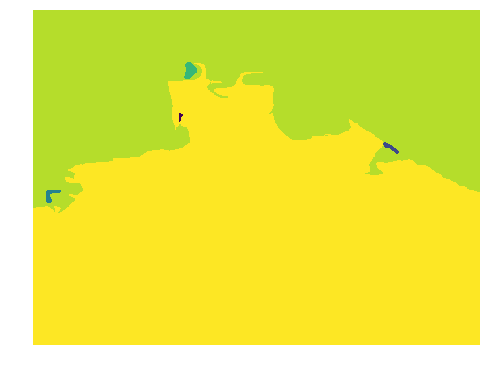

In [164]:
# Sum of two map
map_sum = map_orig.astype('float')+map_inv.astype('float')
map_sum = cv2.normalize(map_sum,None,1, 255,cv2.NORM_MINMAX,cv2.CV_8U)

print(np.unique(map_sum))
show_image(map_sum)

In [ ]:
# _,ax = plt.subplots(1,2, )
# # ax[0].imshow(map_orig)
# ax[0].set_title('From original image')
# ax[0].axis('off')
# ax[1].imshow(map_inv)
# ax[1].set_title('From inverted image')
# ax[1].axis('off');

### Tecture features for all segments 

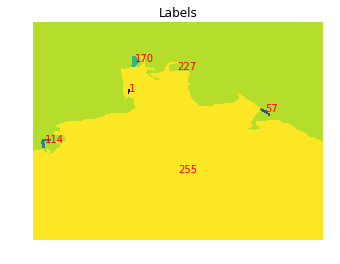

In [165]:
# new labeled image 
segments_postproc = regionprops(map_sum, simg)
segments_postproc = sorted(segments_postproc, key=lambda s: s.area)

plt.imshow(map_sum)
for props in segments_postproc:
    cx, cy = props.centroid  # centroid coordinates
    plt.text(int(cy), int(cx), props.label, fontsize=10, color='red')
plt.axis('off')#
plt.title('Labels');

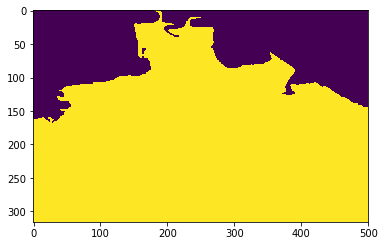

In [196]:
plt.imshow(segments_postproc[-1].image);
bb = segments_postproc[-1].bbox

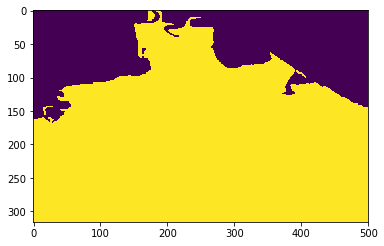

In [197]:
check = mask[bb[0]:bb[2], bb[1]:bb[3]]
plt.imshow(mask[bb[0]:bb[2], bb[1]:bb[3]])

In [199]:
# Check
lVals = (check * segments_postproc[-1].image).ravel().tolist()
max(map(lambda val: (lVals.count(val), val), set(lVals)))[1]

1.0

(113500,)

In [ ]:
temp_mask = np.zeros(mask.shape)
for r, c in segments_postproc[-1].coords:
    temp_mask[r,c] = 1
        
check = (temp_mask*mask).max()
check

In [ ]:
if check == 1: 
    target_floor_label = segments_postproc[-1].label
    features_floor = get_glcm_features(segments_postproc[-1].intensity_image.squeeze())

    target_nonfloor_label = segments_postproc[-2].label
    features_nonfloor = get_glcm_features(segments_postproc[-2].intensity_image.squeeze())

    print('Target label is ', target_floor_label)

elif check == 0:
    target_floor_label = segments_postproc[-2].label
    features_floor = get_glcm_features(segments_postproc[-2].intensity_image.squeeze())

    target_nonfloor_label = segments_postproc[-2].label
    features_nonfloor = get_glcm_features(segments_postproc[-1].intensity_image.squeeze())

    print('Target label is ', target_floor_label)

else:
    print(' ------ Something is wrong -----------')

# For all segments in new labeled image exept of the bigest two 
# find texture features and compare them with target features of flor and non flor 
for props in segments_postproc[:-2]:
    g = get_glcm_features(props.intensity_image.squeeze()) # current feature vector

    # calculate euclidean distance to the 'floor' and 'non floor' points
    floor_dist = pdist(np.concatenate((g,features_floor),axis=0), 'euclidean')
    nonfl_dist = pdist(np.concatenate((g,features_nonfloor),axis=0), 'euclidean')

    # see which point is closer to current segment
    # and relable segment wiht corresponding label
    if floor_dist < nonfl_dist: 
        props.label = target_floor_label
    else: 
        props.label = target_nonfloor_label

# create new binary mask 
mask_postproc = np.zeros(mask.shape, dtype=np.float32) 
for props in segments_postproc:
    if props.label == target_floor_label:
        for r, c in props.coords:
            mask_postproc[r,c] = 1
    else:
        for r, c in props.coords:
            mask_postproc[r,c] = 0

In [ ]:
show_image(mask_postproc)

In [ ]:
# tmp = segments_postproc[-2].coords[10,:]
# mask[tmp[1],tmp[0]]
# cv2.circle(map_sum, (tmp[0],tmp[1]), 5, [100, 100, 0], 5) 
# plt.imshow(map_sum)

In [ ]:
if evaluation:
    gt_floor = get_glcm_features(simg*mask_gt)#/feature_vec_image # area from merging
    gt_nonfloor = get_glcm_features(simg*(1-mask_gt))#/feature_vec_image
    
    print('GT-floor: ', gt_floor)
    print('Obtained: ', features_floor)
    
    print('GT-non: ', gt_nonfloor)   
    print('Obtained: ', features_nonfloor)  

In [ ]:
# # check from ground truth

# if evaluation:
#     # check wiht ground truth 
#     features_floor = get_glcm_features(simg*mask_gt)#/feature_vec_image # area from merging
#     # true non floor? 
#     features_nonfloor = get_glcm_features(simg*(1-mask_gt))#/feature_vec_image

#     # Vizualization of features 
#     feature_matr_postproc = np.zeros([M,N])
#     # calculate features for all sesments exept of the biggest two
#     for i,props in enumerate(segments_postproc[:-2]): 
#         feature_matr_postproc[i, :] = get_glcm_features(props.intensity_image.squeeze())

#     x1 = 0
#     x2 = 1
#     plt.scatter(feature_matr_postproc[:, x1], feature_matr_postproc[:, x2]);
#     plt.scatter(features_floor[:,x1],features_floor[:,x2], marker = 's', c = 'red')
#     plt.scatter(features_nonfloor[:,x1],features_nonfloor[:,x2], marker = 's', c = 'cyan');
    
#     for props in segments_postproc[:-2]:
#         g = get_glcm_features(props.intensity_image.squeeze())
#         floor_dist = pdist(np.concatenate((g,features_floor),axis=0), 'euclidean')
#         nonfl_dist = pdist(np.concatenate((g,features_nonfloor),axis=0), 'euclidean')

#         if floor_dist < nonfl_dist: 
#             props.label = target_floor_label
#         else: 
#             props.label = target_nonfloor_label
    
#     # relable mask by filling segments (x,y) wiht corresponding label 
#     mask_tmp = mask_pred = np.zeros(img_labels.shape, dtype=np.float32) 
#     for i, props in enumerate(segments_postproc):
#         if props.label == target_floor_label:
#             for r, c in props.coords:
#                 mask_postproc[r,c] = 1
#         else:
#             for r, c in props.coords:
#                 mask_postproc[r,c] = 0

#     show_image(mask_tmp)


In [ ]:
for props in segments_postproc[:-2]:
    print(props.area)
    g = get_glcm_features(props.intensity_image.squeeze())
    floor_dist = pdist(np.concatenate((g,features_floor),axis=0), 'euclidean')
    nonfl_dist = pdist(np.concatenate((g,features_nonfloor),axis=0), 'euclidean')
    
    print('To floor: ', floor_dist) 
    print('To non floor: ', nonfl_dist) 
    
    if floor_dist < nonfl_dist: 
        props.label = target_floor_label
        print('So segment is a floor')
    else: 
        props.label = target_nonfloor_label
        print('So segment is not a floor') 
    
    print(' ')

# get_glcm_features(segments_postproc[0].intensity_image.squeeze())

In [ ]:
# relable mask by filling segments (x,y) wiht corresponding label 
mask_postproc = np.zeros(img_labels.shape, dtype=np.float32) 
for i, props in enumerate(segments_postproc):
    if props.label == target_floor_label:
        for r, c in props.coords:
            mask_postproc[r,c] = 1
    else:
        for r, c in props.coords:
            mask_postproc[r,c] = 0

show_image(mask_postproc)

In [ ]:
# # Check with ground truth
# features_floor_gt = get_glcm_features(simg*mask_gt)
# features_nonfloor_gt = get_glcm_features(simg*(1-mask_gt))

# img_labels_postproc = np.zeros_like(img_labels) 
# for props in segments_postproc[:-2]:
#     g = get_glcm_features(props.intensity_image.squeeze())
#     floor_dist = pdist(np.concatenate((g,features_floor_gt),axis=0), 'euclidean')
#     nonfl_dist = pdist(np.concatenate((g,features_nonfloor_gt),axis=0), 'euclidean')
    
#     if floor_dist < nonfl_dist: 
#         props.label = target_floor_label
#     else: 
#         props.label = target_nonfloor_label
    
# for i, props in enumerate(segments_postproc):
#     for r, c in props.coords:
#         if props.label == target_floor_label:
#             img_labels_postproc[r,c] = 1
#         else:
#             img_labels_postproc[r,c] = 0
            
# show_image(img_labels_postproc)
# plt.title('From ground truth')

In [ ]:
type(mask_postproc[0,0])
# type(mask_merged[0,0])
type(cv2.convertScaleAbs(mask_postproc)[0,0])
cv2.convertScaleAbs(mask_postproc).max()

In [ ]:
# # Vizualization of bounding boxes
# imgtmp = img.copy()
# # For each contour, find the bounding rectangle and draw it
# for component in zip(contours, hierarchy[0]):
#     currentContour = component[0]
#     currentHierarchy = component[1]
#     x,y,w,h = cv2.boundingRect(currentContour)
#     if currentHierarchy[2] < 0:
#         # these are the innermost child components
#         cv2.rectangle(imgtmp,(x,y),(x+w,y+h),(255,255,0),3)
#     elif currentHierarchy[3] < 0:
#         # these are the outermost parent components
#         cv2.rectangle(imgtmp,(x,y),(x+w,y+h),(0, 255, 0),3)
#     else:
#         cv2.rectangle(imgtmp,(x,y),(x+w,y+h),(0, 0, 255),3)
# show_image(imgtmp)
# plt.title('Areas of interests')

### Interpolation of a mask 

In [ ]:
# choose mask
mask = mask_merged
mask_interp = np.zeros_like(mask)
contours, hierarchy = cv2.findContours(cv2.convertScaleAbs(mask),
                                       cv2.RETR_TREE,
                                       cv2.CHAIN_APPROX_NONE)   
# Max contour
areas = []
for cnt in contours:
    areas.append(cv2.contourArea(cnt))    
true_contour = contours[np.argmax(areas)]
cv2.drawContours(mask_interp, true_contour, -1, random.rand(3), 3)

# contour approx
epsilon = 0.0005*cv2.arcLength(true_contour, True)
approx = cv2.approxPolyDP(true_contour, epsilon, True)

cv2.fillPoly(mask_interp, [approx], color=(255,255,255))


fig, ax = plt.subplots(1,3, figsize = (8,12))
ax[0].imshow(img_gt)
ax[0].set_title('Ground truth')
ax[0].axis('off')
ax[1].imshow(mask)
ax[1].set_title('Obtained')
ax[1].axis('off')
ax[2].imshow(mask_interp)
ax[2].set_title('Interpolated')
ax[2].axis('off');

## Evaluation

In [ ]:
# Choose mask 
# mask = mask_merged
# mask = mask_pred
# mask = mask_interp

dst = img.copy()
dst[:,:,1] = dst[:,:,1] * (1-mask)

if dst.shape[0] != imh_orig:
    mask = transform.resize(mask, (imh_orig, imw_orig))
    mask[mask <= 0.5] = 0
    mask[mask > 0.5] = 1
    
iou = np.logical_and(mask, img_gt).sum() / np.logical_or(mask, img_gt).sum()

show_image(dst)
# plt.text(50, 50, "IoU: {:.3f}".format(iou), fontsize=14, color = 'red');
print(iou)

np.sum(mask * img_gt) 
mask.sum()